# フラクタル幾何学 

In [17]:
%matplotlib inline
import pylab as pl
import numpy as np

フラクタル幾何学とは、図形の部分と全体が自己相似になっているものなどをいう。

## 反復関数系

反復関数系を用いたシダ状の画像計算の例を以下に示す。
最初に描画する点は原点 $(x_0 = 0, y_0 = 0)$ であり、そこから次の点の座標を計算するため、次の4つの座標変換のうちの1つを無作為に選んで反復的に適用する。

$$
\begin{align}
x_n + 1 &= 0 \\
y_n + 1 &= 0.16 y_n
\end{align}
$$

この座標変換は1%の確率で選択され、右図で緑色で示されている線分上の点の描画に相当する。

$$
\begin{align}
x_n + 1 &= 0.2 x_n − 0.26 y_n \\
y_n + 1 &= 0.23 x_n + 0.22 y_n + 1.6
\end{align}
$$

この座標変換は7%の確率で選択され、右図の黒の四角形内の任意の点から赤の四角形内の図形への写像となる。

$$
\begin{align}
x_n + 1 &= −0.15 x_n + 0.28 y_n \\
y_n + 1 &= 0.26 x_n + 0.24 y_n + 0.44
\end{align}
$$

この座標変換は7%の確率で選択され、右図の黒の四角形内の任意の点から濃い青の四角形内の図形への写像となる。

$$
\begin{align}
x_n + 1 &= 0.85 x_n + 0.04 y_n \\
y_n + 1 &= −0.04 x_n + 0.85 y_n + 1.6
\end{align}
$$

この座標変換は85%の確率で選択され、右図の黒の四角形内の任意の点から青の四角形内の図形への写像となる。

最初の座標変換が茎の描画となる。2番目の座標変換は左下の葉、3番目は右下の葉の描画に相当する。4番目の座標変換は3番目までで描画される部分を縮小して若干傾けてコピーしたものであり、反復的な適用によってシダ全体が描画される。IFSの再帰的性質により、全体がそれぞれの葉を拡大したコピーになっている。なお、ここでは、座標の範囲を -5 <= x <= 5 と 0 <= y <= 10 としている。

### 実装

In [18]:
equations = [
    [0, 0,    0],
    [0, 0.16, 0],
    
    [0.2, -0.26, 0],
    [0.23, 0.22, 1.6],
    
    [-0.15, 0.28, 0],
    [0.26, 0.24, 0.44],
    
    [0.85, 0.04, 0],
    [-0.04, 0.85, 1.6]
]

probabilities = [0.01, 0.07, 0.07, 0.85]

def ifs(p, eq, x, y, n):
    select = np.random.choice(np.arange(0, len(eq), 2), size=n, p=p)
    result = np.zeros((n, 2), dtype=np.float)
    
    for i in range(n):
        j = select[i] 
        a, b, c = eq[j]
        d, e, f = eq[j + 1]
        x2 = a * x + b * y + c
        y2 = d * x + e * y + f
        result[i, 0] = x2
        result[i, 1] = y2
        x, y = x2, y2
        
    return result[:,0], result[:, 1], select

点を描画する関数

In [21]:
def plot_points(x, y, c):
    fig, axes = pl.subplots(1, 1, figsize=(10, 10))
    axes.scatter(x, y, s=1, c=c, marker="s", linewidths=0)  
    axes.set_aspect("equal")
    axes.set_ylim(0, 10.5)
    axes.axis("off")
    return fig, axes

フラクタルの「シダ」

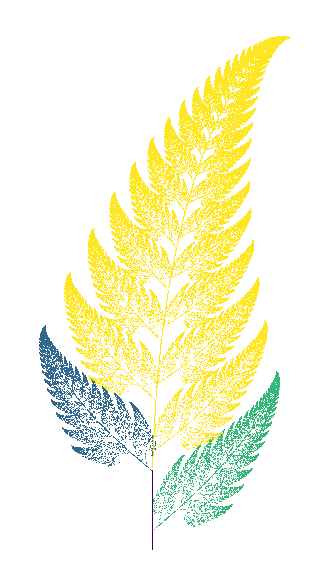

In [22]:
x, y, c = ifs(probabilities, equations, 0.0, 0.0, 100000)
plot_points(x, y, c);

### 計算時間を測る

Pythonが遅い、`%timeit`で計算時間を測ります。

In [4]:
%timeit ifs(probabilities, equations, 0.0, 0.0, 100000)

10 loops, best of 3: 132 ms per loop


### JITで加速

In [23]:
from numba import jit

probabilities_arr = np.array(probabilities)
equations_arr = np.array(equations)
ifs_jit = jit(ifs)

一回目の実行でJITでコンパイルします。

In [24]:
ifs_jit(probabilities_arr, equations_arr, 0.0, 0.0, 100000);

JITした関数の実行時間を測ります。

In [26]:
%timeit ifs_jit(probabilities_arr, equations_arr, 0.0, 0.0, 100000)

100 loops, best of 3: 8.01 ms per loop


## 描画速度について

すべてでの点を描画するではなく、点の分布を統計してから、統計した度数分布を描画します。

In [170]:
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd
from matplotlib import colors

def fast_plot_points(x, y, cmap, bgcolor=None, width=400):
    df_points = pd.DataFrame({"x": x, "y": y})
    height = int(width * df_points.y.ptp() / df_points.x.ptp())
    cvs = ds.Canvas(plot_width=width, plot_height=height)
    agg = cvs.points(df_points, 'x', 'y')
    if bgcolor is None:
        bgcolor = cmap(0)
    img = tf.set_background(tf.shade(agg, cmap=cmap, how='log'), colors.to_hex(bgcolor))
    return img

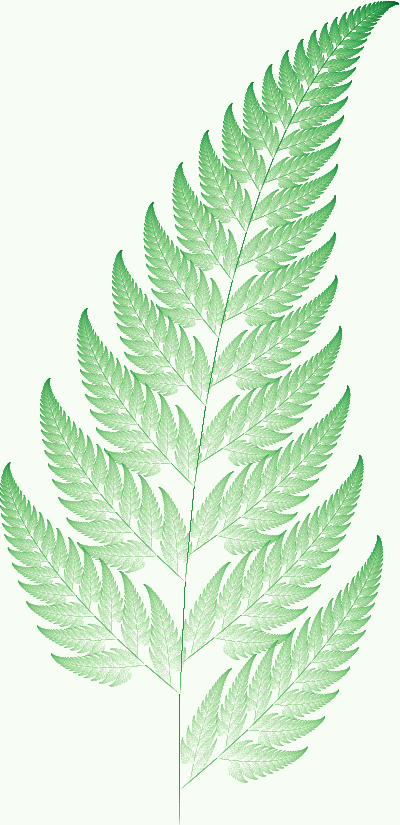

In [171]:
x, y, _ = ifs_jit(probabilities_arr, equations_arr, 0.0, 0.0, 5000000);
fast_plot_points(x, y, cmap=pl.cm.Greens)

### いろいろなフラクタル

In [172]:
from ifs import IFS_DATA
import warnings

warnings.filterwarnings("ignore")

def plot_ifs(ifs):
    x, y, _ = ifs_jit(ifs.get_areas(), ifs.get_eqs(), 0.0, 0.0, 5000000);
    return fast_plot_points(x, y, cmap=pl.cm.get_cmap(ifs.cmap))

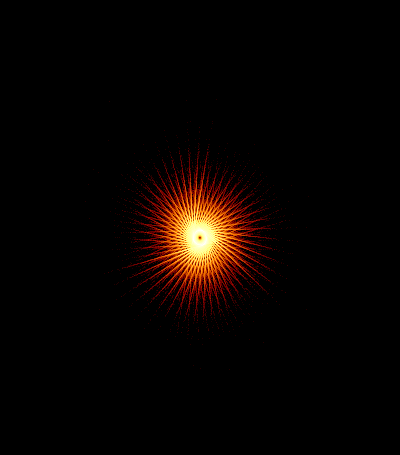

In [181]:
plot_ifs(IFS_DATA[0])

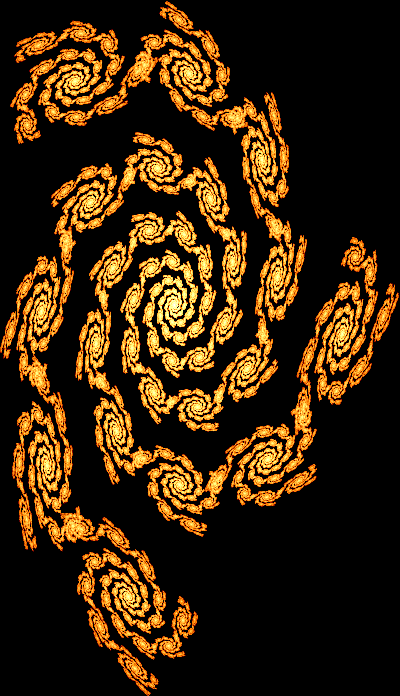

In [183]:
plot_ifs(IFS_DATA[2])

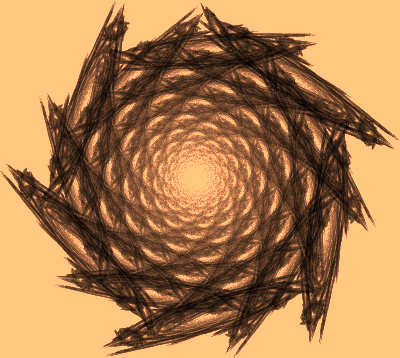

In [184]:
plot_ifs(IFS_DATA[3])

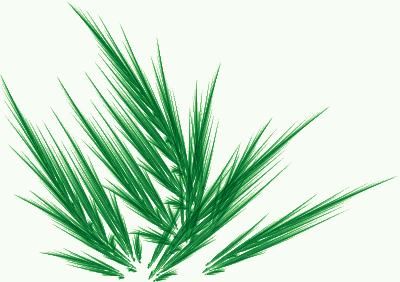

In [185]:
plot_ifs(IFS_DATA[4])

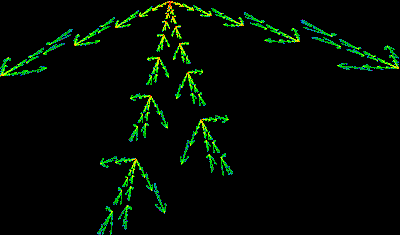

In [186]:
plot_ifs(IFS_DATA[5])

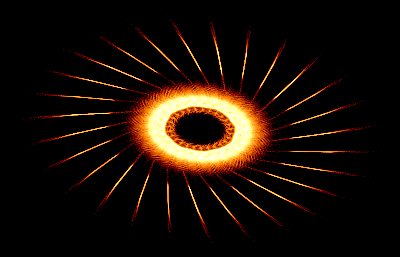

In [187]:
plot_ifs(IFS_DATA[6])

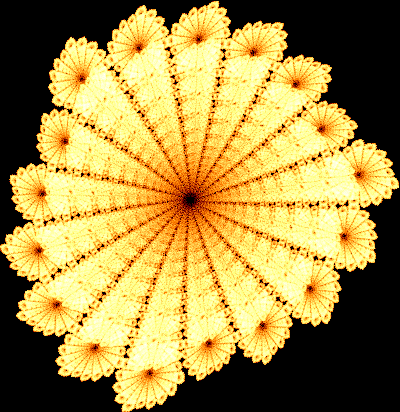

In [188]:
plot_ifs(IFS_DATA[7])

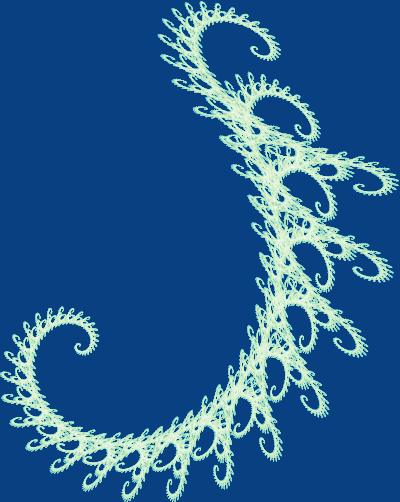

In [189]:
plot_ifs(IFS_DATA[8])

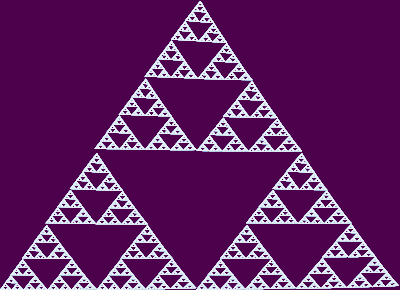

In [190]:
plot_ifs(IFS_DATA[9])

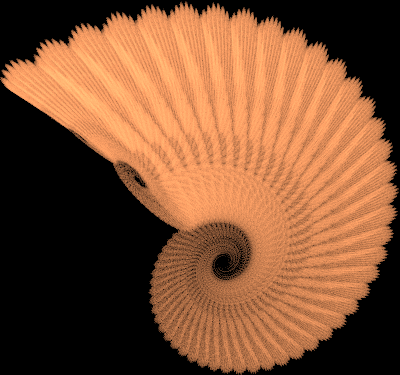

In [191]:
plot_ifs(IFS_DATA[10])

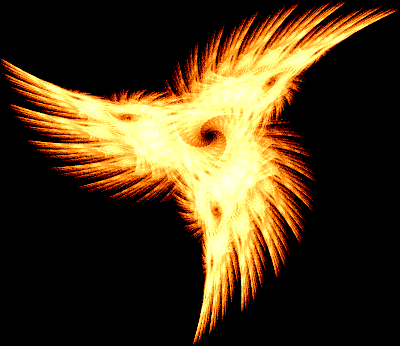

In [192]:
plot_ifs(IFS_DATA[11])